In [13]:
import sys
sys.path.append("../") # go to parent dir to allow imports

from models import mnist_model
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import numpy as np
from numpy.random import uniform

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
img = mnist.test.images[1]
#img = adv_img
#img = uniform(size=(28, 28))

show(img)
#print(np.argmax(sess.run(props, feed_dict={x_data: img.reshape(-1, 784), dropout_rate_data: 0.5})))

uncertainties = []
ys = []
for i in range(50):
    ys.append(sess.run(props, feed_dict={x_data: img.reshape(-1, 784), dropout_rate_data: 0.5})[0])
    
    uncertainties.append(sess.run(tf.square(uncertainty), feed_dict={x_data: img.reshape(-1, 784), dropout_rate_data: 0.5})[0])

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].bar(labels, np.array(ys).mean(axis=0))
axs[1].bar(labels, np.array(uncertainties).mean(axis=0))

In [14]:
ticks = [str(x) for x in range(10)]

def show(img):
    """Displays single mnist digit"""
    plt.imshow(img.reshape([28, 28]), cmap="gray")
    plt.show()
    
def show_with_var(img, prob, var):
    """Display single mnist digit next to the variance per class"""
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].imshow(img.reshape([28, 28]))
    axs[1].bar(ticks, prob)
    axs[2].bar(ticks, var)
    plt.show()
    
def save_img(path, img):
    imageio.imsave(path, img.reshape([28, 28]))
        
mnist = input_data.read_data_sets("../data/MNIST-data", one_hot=True)
adv_img = imageio.imread("adv_img.png").reshape(784)
img = imageio.imread("img.png").reshape(784)
random_img = uniform(size=784)

Extracting ../data/MNIST-data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/t10k-labels-idx1-ubyte.gz


# Crafting Adversarial Examples

The adversarial image is created by projected gradient descent with the pretrained dropout model with no MC Dropout. (http://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/)

The used model is the dropout model, but adversarial images transfer and fool the other models too

In [63]:
def modify_to(img, target, steps=10000):
    tf.reset_default_graph()
    dropout_rate=0.0
    learning_rate=0.001

    x_hat = tf.Variable(tf.zeros((784))) # trainable image
    x = tf.placeholder(tf.float32, 784) # the image will be fed into this placeholder
    dropout_rate = tf.placeholder(tf.float32)

    assign_op = tf.assign(x_hat, x)  # x_hat <- x

    logits, probs = mnist_model.dropout_cnn_mnist_model(x_hat, dropout_rate, reuse=False)

    y_hat = tf.placeholder(tf.int32, ())
    labels = tf.one_hot(y_hat, 10)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])

    optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[x_hat])
    #optim_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=[x_hat])
    epsilon = tf.placeholder(tf.float32, ())

    below = x - epsilon
    above = x + epsilon
    projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
    with tf.control_dependencies([projected]):
        project_step = tf.assign(x_hat, projected)

    init = tf.global_variables_initializer()
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    sess.run(init)

    # Initialize all variables and restore trained weights
    variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:8]
    saver = tf.train.Saver(var_list=variable_list)
    saver.restore(sess, "mnist_dropout.ckpt")
    
    print("Modifying image to {}".format(target))
    demo_epsilon = 0.3
    demo_target = target
    demo_steps = steps

    sess.run(assign_op, feed_dict={x: img})

    for i in range(demo_steps):
        # gradient descent step
        _, loss_value = sess.run(
            [optim_step, loss],
            feed_dict={dropout_rate: 0, y_hat: demo_target})
        # project step
        sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
        if (i+1) % 2500 == 0:
            print('step %d, loss=%g' % (i+1, loss_value))
            #print(np.argmax(sess.run(probs, feed_dict={dropout_rate: 0.4})[0]))

    adv_img = sess.run(x_hat)

    show(adv_img)
    #show(adv_img - img)
    return adv_img

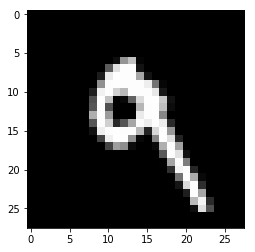

INFO:tensorflow:Restoring parameters from mnist_dropout.ckpt
Modifying image to 5
step 2500, loss=0.0754685
step 5000, loss=0.0419934
step 7500, loss=0.0302822
step 10000, loss=0.023944


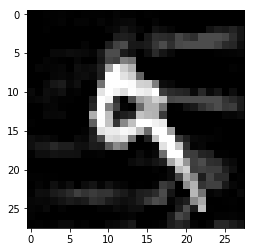

In [64]:
x_test = mnist.test.images
img = x_test[7]  # example image to be modified 
show(img)
adv_img = modify_to(img, 5, steps=10000)
imageio.imsave("adv_img.png", adv_img.reshape([28, 28]))
imageio.imsave("img.png", img.reshape([28, 28]))

# Adversarial Standard Network

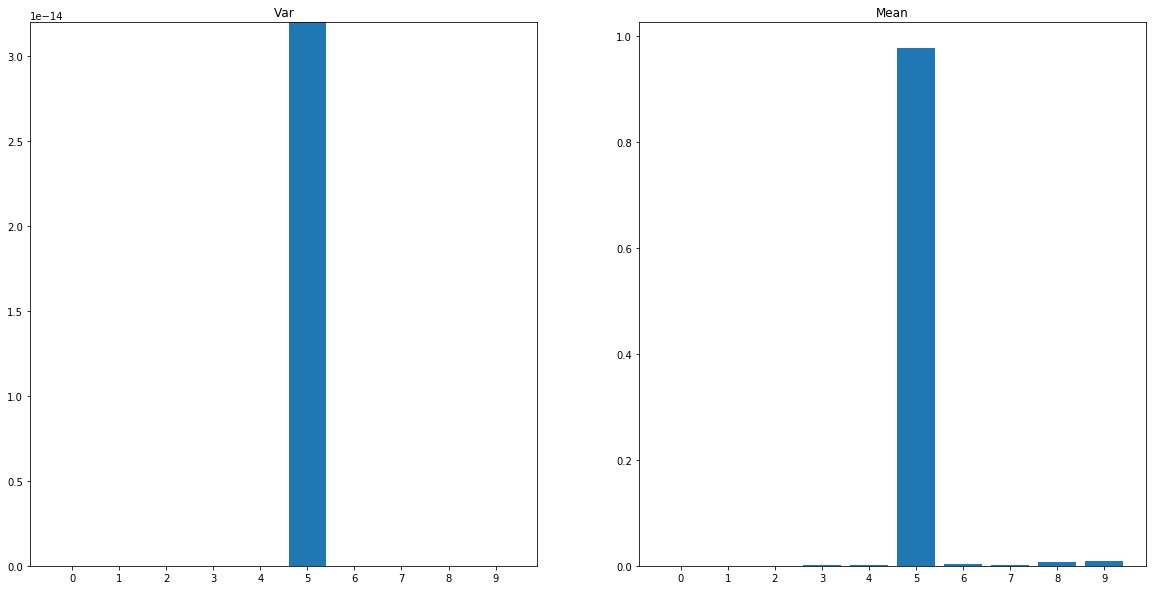

In [74]:
# Needs to have the Dropout model loaded
dropout_inference(adv_img, dropout=0.)

# Adversarial Dropout Network

In [75]:
tf.reset_default_graph()

#x_hat = tf.Variable(tf.zeros((784))) # trainable image
x_data = tf.placeholder(tf.float32, 784) # the image will be fed into this placeholder
dropout_rate_data = tf.placeholder(tf.float32)
n_passes = 50

logits, class_prob = mnist_model.dropout_cnn_mnist_model(x_data, dropout_rate_data)

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:8]
saver = tf.train.Saver(var_list=variable_list)
saver.restore(sess, "mnist_dropout.ckpt")

def dropout_inference(img, dropout=0.5):
    y = []
    for i in range(n_passes):
        y.append(sess.run(class_prob, feed_dict={x_data: img, dropout_rate_data: dropout})[0])

    fig, axs = plt.subplots(1, 2, figsize=[20, 10])
    axs[0].bar(ticks, np.array(y).var(axis=0))
    axs[0].set_title("Var")
    axs[1].bar(ticks, np.array(y).mean(axis=0))
    axs[1].set_title("Mean")

INFO:tensorflow:Restoring parameters from mnist_dropout.ckpt


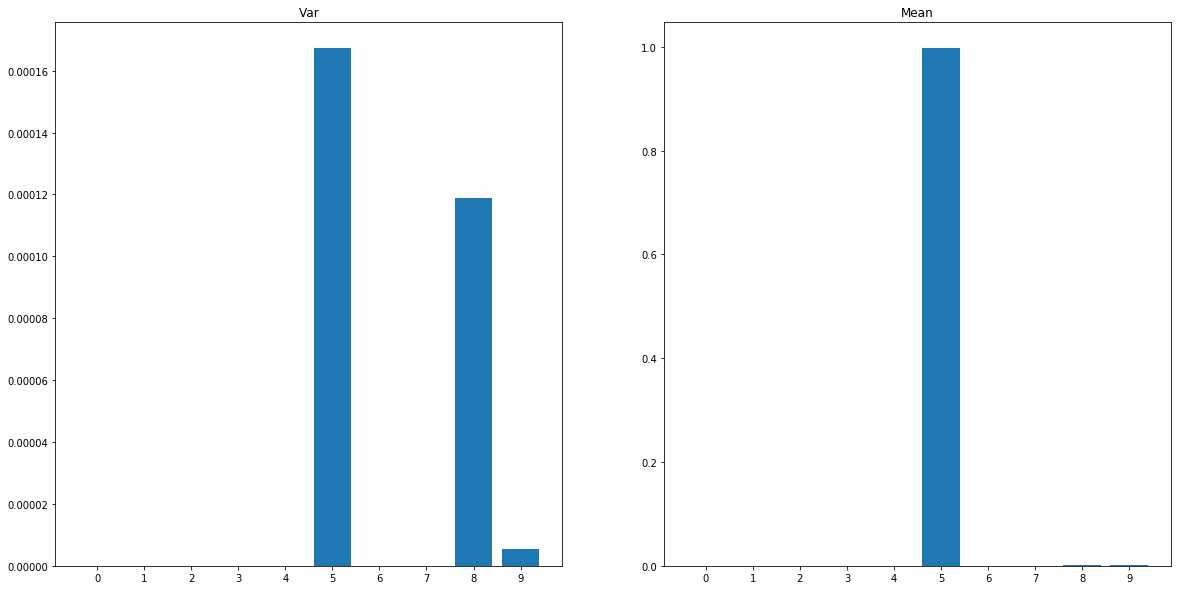

In [78]:
dropout_inference(adv_img, dropout=0.5)

# Adversarial Bootstrap Network

In [79]:
tf.reset_default_graph()

#x_hat = tf.Variable(tf.zeros((784))) # trainable image
x_data = tf.placeholder(tf.float32, 784) # the image will be fed into this placeholder
dropout_rate = tf.placeholder(tf.float32)

heads = mnist_model.bootstrap_cnn_mnist_model(x_data, dropout_rate)

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:16]
saver = tf.train.Saver(var_list=variable_list)
saver.restore(sess, "mnist_boostrap.ckpt")

def bootstrap_inference(img):
    ys = []
    for i, head in enumerate(heads):
        logits, class_prob = head
        y = sess.run(class_prob, feed_dict={x_data: img, dropout_rate: 0.0})[0]
        ys.append(y)

    fig, axs = plt.subplots(1, 2, figsize=[20, 10])
    axs[0].bar(ticks, np.array(ys).var(axis=0))
    axs[0].set_title("Var")
    axs[1].bar(ticks, np.array(ys).mean(axis=0))
    axs[1].set_title("Mean")

INFO:tensorflow:Restoring parameters from mnist_boostrap.ckpt


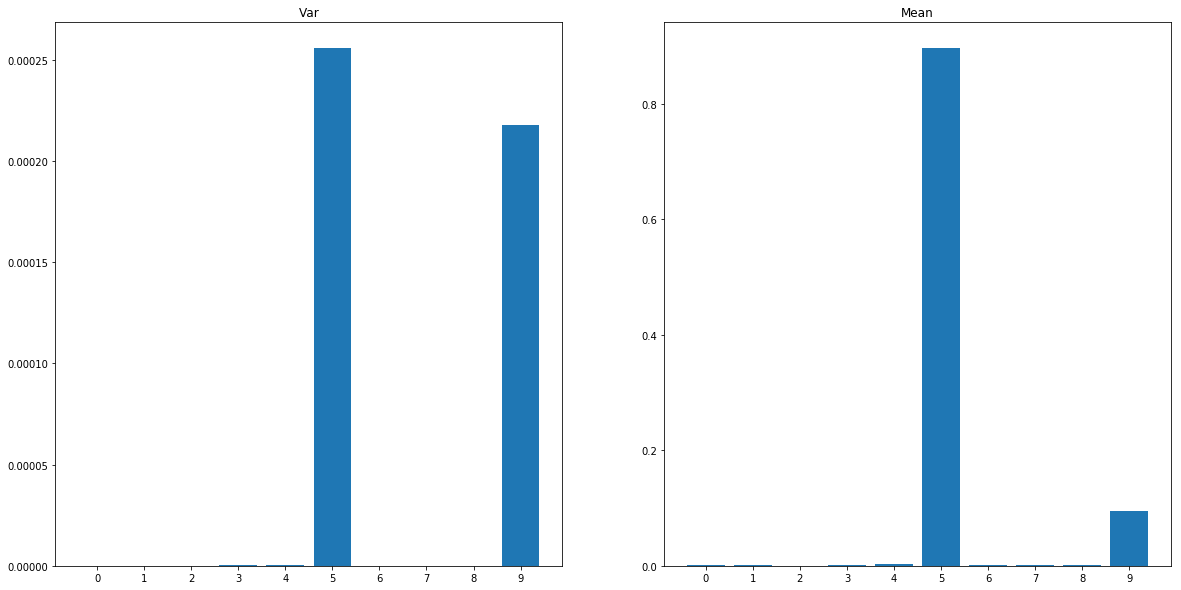

In [80]:
bootstrap_inference(adv_img)

# Adversarial Combined Network